In [1]:
import numpy as np
import matplotlib.pyplot as plt

SynDECA - A Tool to Generate Synthetic Datasets for Evaluation of Cluster Algorithm
- 摘要：  
    聚类算法有很多，而需要数据集来和评估之。本算法自动生成[有生命力的]数据集，评估聚类算法的准确性、抗噪性。  
- 问题描述：  
    给定-数据集大小n，维度d，范围[0 , m]，聚类个数c，噪声比例η  
    输出-随机产生的数据集。
- 步骤：  
    1.确定聚类中心，包括大小边缘  
    2.聚类和噪声大小估计  
    3.填聚类  
    4.撒噪声  

In [2]:
# Input ( as global para 
n = 10000 # total number
d = 2 # dimension
m = 1000 # max value in each dimension
c = 10 # cluster number 
yita = 0.05 # noise-points/cluster-points

# steps
一些内部变量：

$\epsilon$ - 聚类间的最小距离比。任意两个聚类之间的距离不能小于$(1+\epsilon)r$，where r is the radius of a cluster   
$r_{max} , r_{min} $ - 聚类最大/最小半径  
P.S. 噪点数量$\in (0, \frac{1}{1+c}*n] $ (????

In [3]:
# Input (cont.
epsilon = 0.5
r_min = 100
r_max = 300

## step 1
意思大概是，先随机产生中心和半径，放着。冲突就减小，直到没冲突了就安排。

In [4]:
def gapIsEnough(r_i, miu_i, r_j, miu_j):
    def distance(p1,p2):# p1 p2 are 2 points, array type.
        return np.linalg.norm(p1-p2,2) # NOT SURE 
    d = distance(miu_i,miu_j)
    return  (d > r_i + r_j) and (d > r_i *(1 + epsilon)) and (d > r_j *(1 + epsilon)) # NOT SURE

In [5]:
def ClusterPlacement(r_k, miu_k): # miu_k , r_k are miu and r set, respectively
    r_i = np.random.random() * (r_max - r_min) + r_min # in [r_min,r_max]
    miu_i = np.random.random(d) * (m - r_i) + r_i # d-dimension array
    if len(r_k)==0:
        return r_i,miu_i
    else:
        def reduce(r_i):
            return r_i - 0.1*r_min # NOT SURE
        for miu_j, r_j in [(miu_k[i], r_k[i]) for i in range(len(r_k))]:
            while not gapIsEnough(r_i, miu_i, r_j, miu_j) :
                r_i = reduce(r_i)
                if r_i < r_min:
#                     print('too deep iteration wanrning test')
#                     r_i , miu_i = ClusterPlacement(r_k=r_k , miu_k = miu_k) # begin a new random finding
#                     break
                    # 应该是这里迭代次数太多然后爆了
                    return -1,-1
        return r_i , miu_i 
     
test_r_i ,test_miu_i = ClusterPlacement(np.array([]),np.array([]))
TEST_R = np.array([])
TEST_Miu = np.array([])
TEST_COUNTER = 0
for i in range(c):
    while 1:
        TEST_r_new,TEST_miu_new = ClusterPlacement( r_k = TEST_R, miu_k =TEST_Miu)
        if TEST_r_new != -1:
            break
    TEST_R = np.append(TEST_R , TEST_r_new)
    TEST_Miu = np.append(TEST_Miu, TEST_miu_new)
    TEST_Miu = TEST_Miu.reshape(int(len(TEST_Miu)/d),d)
    
    TEST_COUNTER+=1
    if TEST_COUNTER==c:
        break

TEST_R,TEST_Miu
# 目测爆炸概率40%

(array([261.33280622, 179.59613912, 103.02822273, 202.31398244,
        134.36421244, 109.23500914, 101.43149745, 105.26735526,
        102.10740261, 104.66313425]), array([[311.90220568, 493.63458512],
        [377.29686476, 934.83244574],
        [734.50026503, 187.83180061],
        [727.63377685, 735.6608976 ],
        [957.69032477, 286.1377939 ],
        [984.87686657, 556.19883494],
        [942.47598094, 952.65421307],
        [708.58119404, 403.54697433],
        [158.53948389, 123.13236102],
        [444.61855896, 117.29461486]]))

## step 2
n Number  
miu_j Center  
r_j Shape  
Xj   
shape = [-1,0,1,2] # Irregular, Circle, Square, Ellipse, Rectangle,  


In [6]:
def generate_point(miu_i, r_i):
    return ( 2*np.random.random(d) -1 )* r_i + miu_i 
generate_point(miu_i=test_miu_i,r_i=test_r_i)

array([674.54565308, 388.38981228])

In [7]:
def sprinkle_point(p, eps, min_pts): # sprinkle surrounding the point p
    # reverse DB-SCAN
    points = np.array([])
    for i in range(min_pts):
        # NOT SURE: "around" here means "within the bounding box". 
        points = np.append(points,generate_point(p, eps)) # note that np.array + array means matrix plus
    return points.reshape(min_pts,2)
# sprinkle_point(p=test_miu_i, eps=0.01, min_pts=10)

In [8]:
def get_a_point(p, eps, eps_):
    # randomly generate a point with distance of q_, where eps < q_ < eps + eps_ 
    while True:
        p_ = generate_point(miu_i=p, r_i=eps+eps_)
        if np.linalg.norm(p_-p,2) > eps and np.linalg.norm(p_-p,2) < eps+eps_ :
            break
    return p_
get_a_point(test_miu_i, eps=0.001, eps_=0.002)

array([810.09530425, 363.53967188])

In [9]:
def is_within_cluster_area(shape, point, miu_i, r_i, rad_i):
    if shape == 0: # Rectangle. Rad_i = half length in every demension 
        return (abs(point - miu_i)/rad_i < 1 ).all() 
    if shape == 1: # Ellipse. Rad_i = half length in every demension
        return sum((point-miu_i)**2/rad_i)<1
def ClusterPointsGeneration(n_j, r_j, miu_j, shape, rad_i, alpha): # generate n_j points surrounding the cluster center miu_j
    points=np.array([])
    if shape == -1 : #irregular
        eps=0.02*r_j
        eps_=0.05*r_j
        # initial point p
        p = generate_point(r_i=r_j, miu_i=miu_j )
        min_pts = int(alpha * n_j)
        points = sprinkle_point(p=p, eps=eps, min_pts=min_pts)
        # iteration p_
        debuggerCounter=0
        while len(points) < n_j:
            p_ = get_a_point(p,eps,eps_)
            points = np.vstack([points, sprinkle_point(p=p_, eps=eps_, min_pts=min_pts)])
            p=p_
            eps = eps_ #NOT SURE
    else:
        while len(points) < n_j:
            p = generate_point(r_i=r_j, miu_i=miu_j )
            if is_within_cluster_area(shape=shape, point=p, miu_i=miu_j, r_i=r_j, rad_i=rad_i):
                if len(points)==0:
                    points = p
                else:
                    points = np.vstack([p,points])
    return points
# Test
# points = ClusterPointsGeneration(n_j=100, r_j=test_r_i, miu_j=test_miu_i, shape=-1,rad_i=[150,260], alpha=0.03)
points = ClusterPointsGeneration(n_j=100, r_j=test_r_i, miu_j=test_miu_i, shape=0,rad_i=[150,260], alpha=0.03)
# points = ClusterPointsGeneration(n_j=100, r_j=test_r_i, miu_j=test_miu_i, shape=1,rad_i=[150,260], alpha=0.03)


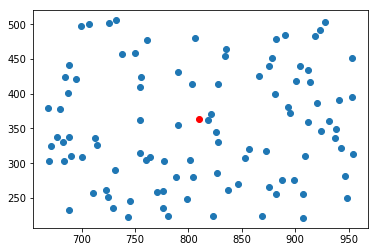

In [10]:
plt.scatter(test_miu_i[0],test_miu_i[1],c='r')
plt.scatter([i[0] for i in points],[i[1] for i in points])

## step 3
不在任何一个聚类内

给定：
yita ，噪点比  
n 总数  
(miu_k, f_k) miu_k - 聚类中心。f_k 包括半径r_k, shape_k, rad_ik, eps_k **这意味着之前的这些信息都要留下来**  
m 范围  


In [11]:
def NoisePointsGeneration(yita, n, miu_k, r_k, shape_k, radi_k, eps_k, m):
    noise_points = np.array([])
    while len(noise_points)< n*yita:
        point = np.random.random(d) * m
        if [ point - miu_k[i] > r_k[i] ].all(): # out of bounding
            if len(points)==0:
                noise_points = point 
            else:
                noise_points = np.vstack([point,noise_points])
        else:
            
    return noise_points


IndentationError: expected an indented block (<ipython-input-11-b320b8308c6c>, line 12)

## 总
并把参数全部写一遍

In [12]:
n = 1000 # total number
d = 2 # dimension
m = 1000 # max value in each dimension
c = 10 # cluster number 
yita = 0.05 # noise-points/cluster-points

epsilon = 1
r_min = 100
r_max = 500

In [14]:
# step1
r = np.array([])
miu = np.array([])

for i in range(c):
    r_new,miu_new = ClusterPlacement(r_k = r, miu_k = miu)
    r = np.append(r,r_new)
    miu = np.append(miu,miu_new)
    miu = miu.reshape(int(len(miu)/d),d)

(r,miu)
# 目测爆炸概率50%

ValueError: cannot reshape array of size 3 into shape (1,2)

In [ ]:
# step2
n_j=n/c # equally divided
rad = np.array([ np.random.random(d)*r[i] for i in range(c)])
alpha = np.array([0.03 for i in range(n)])
shape = np.array([1 for i in range(n)])
points = ClusterPointsGeneration(n_j=n_j, r_j=r[0], miu_j=miu[0], shape=1,rad_i=rad[0], alpha=0.03)

In [ ]:
for i in range(1,c):
    points = np.vstack([
        points , ClusterPointsGeneration(n_j=n_j, r_j=r[i], miu_j=miu[i], shape=shape[i],rad_i=rad[i], alpha=0.03)
   ])

In [ ]:
points

In [ ]:
plt.figure(figsize=(20,20))

for i in miu:
    plt.scatter(i[0],i[1],c='r')
plt.scatter([i[0] for i in points],[i[1] for i in points],s=1)